In [4]:
import numpy as np
import pandas as pd
import mlflow
import logging
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import shap

In [5]:
logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)
logger


<Logger __main__ (WARNING)>

In [6]:

import dagshub
dagshub.init(repo_owner='kriti.srivastava002', repo_name='Crop-Production', mlflow=True)
mlflow.autolog()

Initialized MLflow to track repo "kriti.srivastava002/Crop-Production"

Repository kriti.srivastava002/Crop-Production initialized!

2024/06/18 15:22:41 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


In [7]:
file =("./data/crop_production.csv")
df = pd.read_csv(file, delimiter=',')
print(df)
print(df.describe())

                         State_Name District_Name  Crop_Year       Season  \
0       Andaman and Nicobar Islands      NICOBARS       2000  Kharif        
1       Andaman and Nicobar Islands      NICOBARS       2000  Kharif        
2       Andaman and Nicobar Islands      NICOBARS       2000  Kharif        
3       Andaman and Nicobar Islands      NICOBARS       2000  Whole Year    
4       Andaman and Nicobar Islands      NICOBARS       2000  Whole Year    
...                             ...           ...        ...          ...   
246086                  West Bengal       PURULIA       2014  Summer        
246087                  West Bengal       PURULIA       2014  Summer        
246088                  West Bengal       PURULIA       2014  Whole Year    
246089                  West Bengal       PURULIA       2014  Winter        
246090                  West Bengal       PURULIA       2014  Winter        

                       Crop      Area  Production  
0                  Arec

In [8]:
print(df.shape)
print(df.isnull().sum())
df.fillna(0,inplace=True)
df.drop_duplicates()
sum_maxp = df["Production"].sum()
print(sum_maxp)
df["percent_of_production"] = df["Production"].map(lambda x:(x/sum_maxp)*100)
data = df.drop(["State_Name","District_Name", "Crop_Year"],axis=1)
data_dum = pd.get_dummies(data, dtype='int')
    
X = data_dum.drop("Production",axis=1).values
y = data_dum["Production"].values

(246091, 7)
State_Name          0
District_Name       0
Crop_Year           0
Season              0
Crop                0
Area                0
Production       3730
dtype: int64
141176116767.38995


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X , y, 
                                                        shuffle = True, 
                                                        test_size=0.25, 
                                                        random_state=1)
    
print('Shape of training feature:', X_train.shape)
print('Shape of testing feature:', X_test.shape)
print('Shape of training label:', y_train.shape)
print('Shape of training label:', y_test.shape)



with mlflow.start_run():
  # Your training code here...
  mlflow.log_param('Param name', 'Value')
  model = LinearRegression()
  model.fit(X_train,y_train)
  preds = model.predict(X_test)
  print(f"The r2 score for this model is : {r2_score(y_test,preds)}")
  mlflow.log_metric('r2 score' , r2_score(y_test,preds))
  print(model.coef_)
  #mlflow.log_metric('Model coefficient', model.coef_)
  print(model.intercept_)
  mlflow.log_param('Intercept', model.intercept_)

  


Shape of training feature: (184568, 132)
Shape of testing feature: (61523, 132)
Shape of training label: (184568,)
Shape of training label: (61523,)
The r2 score for this model is : 1.0
[-1.53752436e-10  1.41176117e+09  2.59932131e-05  1.95465982e-05
  2.18972564e-05  1.97812915e-05  1.93119049e-05  2.28136778e-05
 -3.61554325e-04  4.99188900e-05 -1.35064125e-04 -2.18153000e-05
 -8.23736191e-05  4.58955765e-06 -2.23517418e-05  3.43918800e-05
 -2.36034393e-05  2.61783600e-04  2.00390816e-04  1.94668770e-04
  7.49230385e-05  8.46385956e-05 -4.62234020e-05  6.42538071e-05
  5.93662262e-05  2.73883343e-05  8.14497471e-05 -2.02655792e-06
 -2.15917826e-05 -1.05932355e-04 -4.72515821e-05  1.44034624e-04
 -8.62926245e-05 -2.53580511e-05 -4.12911177e-05 -5.42812049e-05
 -2.67028809e-05  8.41438770e-04 -1.84401870e-05  2.49341130e-04
 -7.06110150e-05 -2.22921371e-05  1.47366896e-04  8.35210085e-06
 -6.59972429e-05 -2.29179859e-05 -1.82315707e-05 -4.26322222e-05
  1.23791397e-04 -2.39163637e-05  

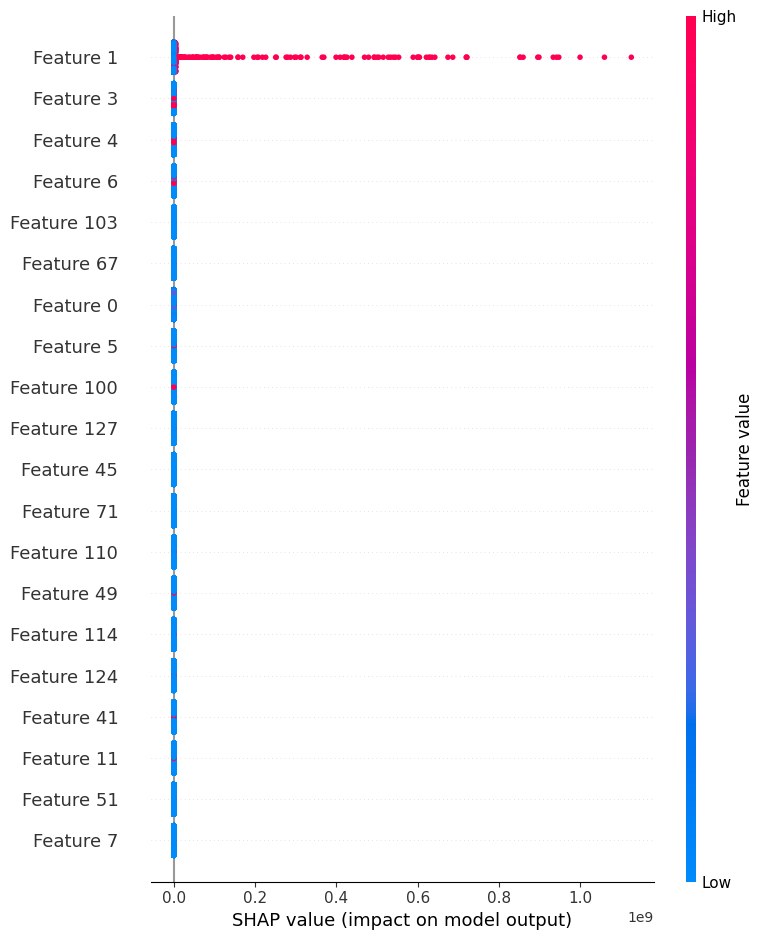

In [17]:

explainer = shap.LinearExplainer(model, X_test)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)



In [ ]:
seasons= list(set(df["Season"]))
crops= list(set(df["Crop"]))
seasons.sort()
print(seasons)
crops.sort()
print(crops)
cols= list(data_dum.columns)
cols=cols[4:]



['Autumn     ', 'Kharif     ', 'Rabi       ', 'Summer     ', 'Whole Year ', 'Winter     ']
['Apple', 'Arcanut (Processed)', 'Arecanut', 'Arhar/Tur', 'Ash Gourd', 'Atcanut (Raw)', 'Bajra', 'Banana', 'Barley', 'Bean', 'Beans & Mutter(Vegetable)', 'Beet Root', 'Ber', 'Bhindi', 'Bitter Gourd', 'Black pepper', 'Blackgram', 'Bottle Gourd', 'Brinjal', 'Cabbage', 'Cardamom', 'Carrot', 'Cashewnut', 'Cashewnut Processed', 'Cashewnut Raw', 'Castor seed', 'Cauliflower', 'Citrus Fruit', 'Coconut ', 'Coffee', 'Colocosia', 'Cond-spcs other', 'Coriander', 'Cotton(lint)', 'Cowpea(Lobia)', 'Cucumber', 'Drum Stick', 'Dry chillies', 'Dry ginger', 'Garlic', 'Ginger', 'Gram', 'Grapes', 'Groundnut', 'Guar seed', 'Horse-gram', 'Jack Fruit', 'Jobster', 'Jowar', 'Jute', 'Jute & mesta', 'Kapas', 'Khesari', 'Korra', 'Lab-Lab', 'Lemon', 'Lentil', 'Linseed', 'Litchi', 'Maize', 'Mango', 'Masoor', 'Mesta', 'Moong(Green Gram)', 'Moth', 'Niger seed', 'Oilseeds total', 'Onion', 'Orange', 'Other  Rabi pulses', 'Other Cer

In [ ]:
import gradio as gr

def greet(area, percent, season, crop):
    arr= np.zeros(132, dtype=np.float64)
    arr[0]= area
    arr[1]= percent
    
    i=2
    j=0
    while i<8 and j<6 :
        arr[i]= float(season== seasons[j])
        i+=1
        j+=1
    j=0
    while i<len(cols) and j<len(cols):
        arr[i]=float(crop==crops[j])
        i+=1
        j+=1

    arr= arr.reshape(-1, len(arr))
    preds = model.predict(arr)
    return preds[0]
    
demo = gr.Interface(
    greet,
    inputs=[  
        gr.Number(),
        gr.Number(),
        gr.Radio(seasons),
        gr.Dropdown(crops),
     
    ],
    outputs=[gr.Textbox(label="Model Prediction")],
    title="Crop Production Prediction",
    description="This application has a machine learning model in the backend which predicts the production this year using the area, percent of production, season and the crop."
)
demo.launch()



Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.
